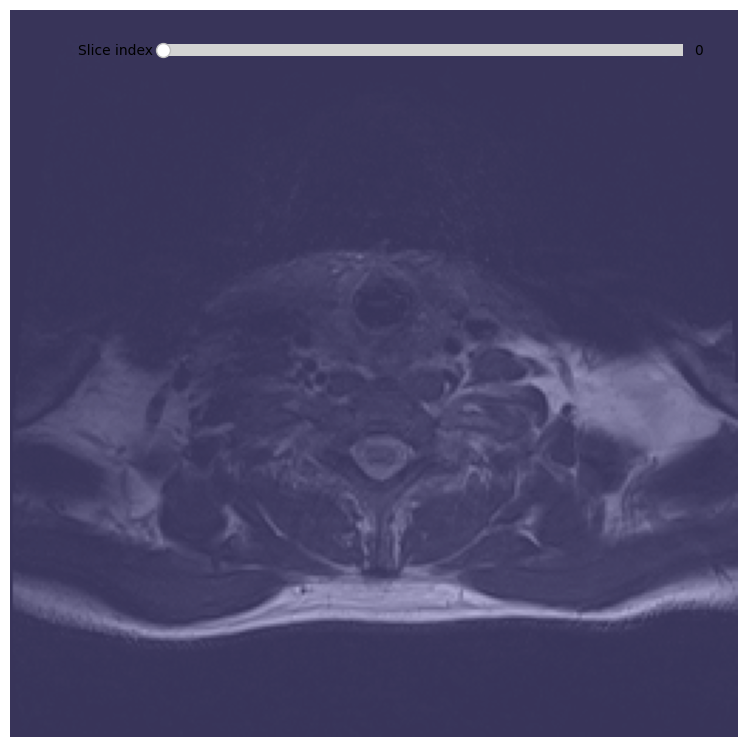

In [13]:
import torch
import monai

from monai.transforms import (
    Compose,
    Resized,
    Spacingd,
    SpatialCropd,
    NormalizeIntensityd,
    RandSpatialCropd,
    RandFlipd,
    RandScaleIntensityd,
    RandShiftIntensityd,
    Orientationd, Activations, AsDiscrete,
)
from torch.utils.tensorboard import SummaryWriter

from dataset import HNTSDataset
from slice_slider import dataset
from train_basic import post_trans
from trainer import MedSegTrainer

In [14]:
class Config:
    device = "cuda"
    batch_size = 1
    epochs = 1
    lr_init = 1e-2
    lr_min = 1e-5
    cpu_cores = 8
    weight_decay = 1e-5
    smooth_nr = 0
    smooth_dr = 1e-5


config = Config()

In [15]:
train_transforms = Compose(
    [
        # Normalization and cropping
        RandSpatialCropd(
            keys=["image", "mask"], roi_size=[256, 256, 96], random_size=False
        ),
        RandFlipd(keys=["image", "mask"], prob=0.5, spatial_axis=0),
        RandFlipd(keys=["image", "mask"], prob=0.5, spatial_axis=1),
        RandFlipd(keys=["image", "mask"], prob=0.5, spatial_axis=2),
        NormalizeIntensityd(keys="image", nonzero=True),
        RandScaleIntensityd(keys="image", factors=0.1, prob=1.0),
        RandShiftIntensityd(keys="image", offsets=0.1, prob=1.0),
    ]
)
train_dataset = HNTSDataset("data/train", transform=train_transforms)
train_loader = monai.data.DataLoader(
    train_dataset,
    batch_size=config.batch_size,
    shuffle=True,
    num_workers=config.cpu_cores,
)

In [16]:
test_transforms = Compose(
    [
        # Normalization
        # SpatialCropd(
        #     keys=["image", "mask"], roi_center=[256, 256, 40], roi_size=[256, 256, 96]
        # ),
        # Resized(
        #     keys=["image", "mask"],
        #     spatial_size=(256, 256, 96),
        #     mode=("bilinear", "nearest"),
        # ),
        NormalizeIntensityd(keys="image"),
    ]
)
test_dataset = HNTSDataset("data/test", transform=test_transforms)
test_loader = monai.data.DataLoader(
    test_dataset,
    batch_size=config.batch_size,
    shuffle=False,
    num_workers=config.cpu_cores,
)

In [17]:
# model = monai.networks.nets.SwinUNETR(
#     in_channels=1,
#     out_channels=2,
#     img_size=(256, 256, 96),
#     spatial_dims=3,
#     use_checkpoint=False,
#     use_v2=True,
# ).to(config.device)

In [18]:
model = monai.networks.nets.UNet(
    spatial_dims=3,
    in_channels=1,
    out_channels=2,
    channels=(1, 1, 1, 1),
    strides=(2, 2, 2),
    num_res_units=2,
).to(config.device)

In [19]:
optimizer = torch.optim.Adam(model.parameters(), config.lr_init, weight_decay=config.weight_decay)
lr_scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(
    optimizer, T_max=config.epochs, eta_min=config.lr_min
)
loss_function = monai.losses.DiceLoss(
    smooth_nr=config.smooth_nr,
    smooth_dr=config.smooth_dr,
    squared_pred=True,
    to_onehot_y=False,  # labels are already separated by channel
    sigmoid=True,  # 0 is background, 1 is label
    # weight=torch.tensor([1.1886071e+00, 8.6305177e-01]).to(config.device)
)
writer = SummaryWriter("logs/exp1/writer")
trainer = MedSegTrainer(
    epochs=config.epochs,
    optimizer=optimizer,
    lr_scheduler=lr_scheduler,
    loss_f=loss_function,
    logger=writer
)
print("Fitting model")
# trainer.fit(model=model, train_loader=train_loader)

print("\nTesting model")
# score = trainer.test(
#     model=model,
#     test_loader=test_loader,
#     post_trans=Compose([
#         Activations(sigmoid=True),  # sigmoid so its between 0 and 1
#         AsDiscrete(threshold=0.5)  # 0 is background, 1 is the label
#     ])
# )
# for i in range(score.shape[0]):
#     print(f"Dice score [{test_dataset.id_to_label[i]}]: {score[i].item():.3f}")


Fitting model

Testing model


In [28]:
from monai.inferers import sliding_window_inference


def inference(model, input):
    def _compute(input):
        return sliding_window_inference(
            inputs=input,
            roi_size=(240, 240, 160),
            sw_batch_size=1,
            predictor=model,
            overlap=0.5,
        )

    with torch.amp.autocast('cuda'):
        return _compute(input)

pred = inference(model, test_dataset[0]['image'].unsqueeze(0).to(config.device))[0]
post_trans = Compose([Activations(sigmoid=True), AsDiscrete(threshold=0.5)])
pred = post_trans(pred)